# Dataset Modification Experiment

Here we're going to create a few classification models (Logistic Regression, Support Vector Machine (SVM), Random Forest, and a Neural Network) for a modified version of the Human Activity Recognition Using Smartphones dataset.

Here the training and test data have been merged where the instances in the test set have been added below the instances of the training set and combined to form a single dataset we've named HAR-Merged.csv

As usual we import the packages we need.

NumPy: For numerical operations.
Pandas: For data manipulation and ingestion.
Matplotlib: For plotting graphs.
Scikit-learn: For machine learning algorithms and data preprocessing.
TensorFlow: This also installs Keras, which is now part of TensorFlow for neural network architectures.

In your chosen terminal enter the following command to install the appropriate libraries

**pip install numpy pandas matplotlib scikit-learn tensorflow**


You can find information about them at their respective documentaiton sites.
- https://numpy.org/doc/stable/user/index.html#user
- https://pandas.pydata.org/docs/user_guide/10min.html
- https://scikit-learn.org/stable/user_guide.html
- https://matplotlib.org/stable/index.html

The first thing we need to do is import the packages we need.
**You can add the import for pandas yourself - import it as 'pd'**

Once that's done continue you can run the cell with the play button or the run all button pictured in the practical document.
Start working your way through the notebook running the cells as you go.

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Load and Modify the Dataset
Our chosen dataset was sourced from the Kaggle dataset repository
https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

The original dataset with more information can be found here:
Reyes-Ortiz, J., Anguita, D., Ghio, A., Oneto, L., & Parra, X. (2013). Human Activity Recognition Using Smartphones [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C54S4K.
https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones


The first thing to do is load the data we're going to work with and have a quick look at a summary of it.
Pandas gives us a function to read CSV files.

In this case we will load the **HAR-Merged.csv** file 
After which we will shuffle the instances by class
Generate the shuffled dataset and export it as **shuffled_data.csv** to the same directory

**You might need update the location of the dataset files to point to the correct place you saved it to!**
If running in Jupyter upload the files into the same folder as the jupyter file 
"./" means "from where we are now"

In [41]:
# Load HAR-Merged.csv
df = pd.read_csv('./HAR-Merged.csv')


# Assuming 'df' is your DataFrame and 'Activity' is the column that uniquely identifies each group
# Shuffle within groups
grouped = df.groupby('Activity', group_keys=False)  # Do not create an index based on the group key
shuffled_within_groups = grouped.apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

# Shuffle the groups
# We create a unique list of group_ids, shuffle them, and then concatenate the dataframes in the new order
unique_groups = pd.DataFrame(df['Activity'].unique(), columns=['Activity']).sample(frac=1)
shuffled_df = pd.concat([shuffled_within_groups[shuffled_within_groups['Activity'] == group] for group in unique_groups['Activity']], ignore_index=True)

print(shuffled_df.shape)

(10299, 563)


## Data Split
Next we need to split the dataset into two parts: inputs and expected outputs.
Usually these are referred to as 'X' and 'Y'.

In this experiment X will be our inputs and Y our outputs for training the models

We will then manually split the data into a 60/40 train-test configuration

In [45]:
# Assuming 'Activity' is the column with class labels
Y = shuffled_df['Activity'].values  # Use this column as your class labels
X = shuffled_df.drop(columns=['Activity']).values  # Drop this column from the features

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Scale data for better performance of many models

# Convert class labels to binary format for neural network
lb = LabelBinarizer()
Y_nn = lb.fit_transform(Y)

# Split the data with a random state
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X, Y_nn, test_size=0.4, random_state=42)  # For neural network

## Model Training
Now we fit the machine learning models we're going to use to our data.

In [46]:
# Initialize models
logistic_model = LogisticRegression(C=1/0.1, solver="liblinear", random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Neural Network Model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(Y_nn.shape[1], activation='softmax')  # Output layer nodes equal to number of classes
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit models
logistic_model.fit(X_train, Y_train)
random_forest_model.fit(X_train, Y_train)
svm_model.fit(X_train, Y_train)
nn_model.fit(X_train_nn, Y_train_nn, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
618/618 [==============================] - 1s 968us/step - loss: 0.2591 - accuracy: 0.9005
Epoch 2/10
618/618 [==============================] - 1s 958us/step - loss: 0.0983 - accuracy: 0.9649
Epoch 3/10
618/618 [==============================] - 1s 959us/step - loss: 0.0880 - accuracy: 0.9662
Epoch 4/10
618/618 [==============================] - 1s 958us/step - loss: 0.0688 - accuracy: 0.9731
Epoch 5/10
618/618 [==============================] - 1s 958us/step - loss: 0.0577 - accuracy: 0.9775
Epoch 6/10
618/618 [==============================] - 1s 956us/step - loss: 0.0565 - accuracy: 0.9782
Epoch 7/10
618/618 [==============================] - 1s 956us/step - loss: 0.0427 - accuracy: 0.9835
Epoch 8/10
618/618 [==============================] - 1s 963us/step - loss: 0.0265 - accuracy: 0.9895
Epoch 9/10
618/618 [==============================] - 1s 959us/step - loss: 0.0606 - accuracy: 0.9783
Epoch 10/10
618/618 [==============================] - 1s 955us/step - loss: 0.038

## Evaluate the Models
Now what we have a completed our models we need to see how accurate they are.
The simplest way to do this is to just have them predict the output for the test data and see how many they got correct and return that as as percentage value between 0-1.

In [49]:
# Predictions on test data
logistic_predictions = logistic_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
nn_predictions = nn_model.predict(X_test)
nn_predictions = lb.inverse_transform(nn_predictions)  # Convert probabilities to class labels


# Performance Evaluation
print("Logistic Regression Accuracy:", accuracy_score(Y_test, logistic_predictions))
print("Random Forest Accuracy:", accuracy_score(Y_test, random_forest_predictions))
print("SVM Accuracy:", accuracy_score(Y_test, svm_predictions))
print("Neural Network Accuracy:", accuracy_score(Y_test, nn_predictions))

Logistic Regression Accuracy: 0.9857605177993527
Random Forest Accuracy: 0.976051779935275
SVM Accuracy: 0.9766990291262136
Neural Network Accuracy: 0.9773462783171522


### Further Evaluation
A more thourough evaluation method is to look at the receiver operating characteristic (ROC) curve and area under the ROC curve (AUC).
The ROC curve lets us look at how the models perform under different "thresholds".
The threshold we set lets us look at the potential trade off for the true positive rate and the false positive rate.
Ideally we want the ROC curve to end up as close to the upper left corner (high true posite rate, low false positive rate) as we can get it.
Similarly we want the area under the curve to be as high as possible.
Like accuracy AUC is a percentage in the range 0-1.

In [50]:
# Optionally compute ROC AUC (note: need to handle multi-class or binary case separately)
# logistic_auc = roc_auc_score(Y_test, logistic_model.predict_proba(X_test), multi_class='ovr')
# print("Logistic Regression AUC:", logistic_auc)
def plot_roc_curve(Y_test, Y_scores, classes):
    # Compute ROC curve and ROC area for each class in a one-vs-rest manner
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Prepare figure
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test == classes[i], Y_scores[:, i])
        roc_auc[i] = roc_auc_score(Y_test == classes[i], Y_scores[:, i])
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

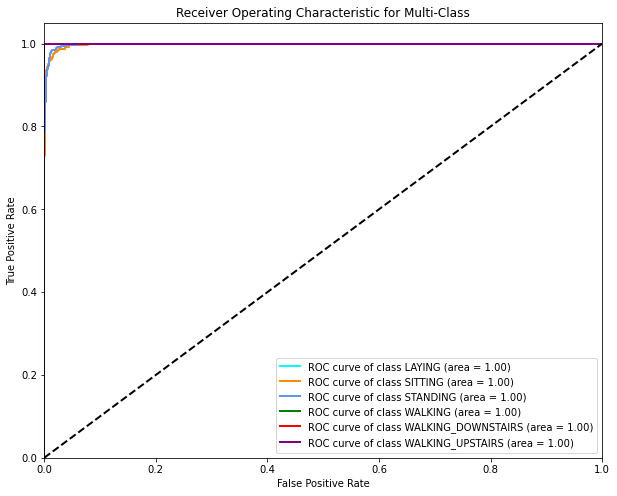

Logistic Regression ROC AUC per class: {0: 1.0, 1: 0.9981517521824558, 2: 0.9985850856926367, 3: 0.9999940229325136, 4: 1.0, 5: 0.9999938223938224}


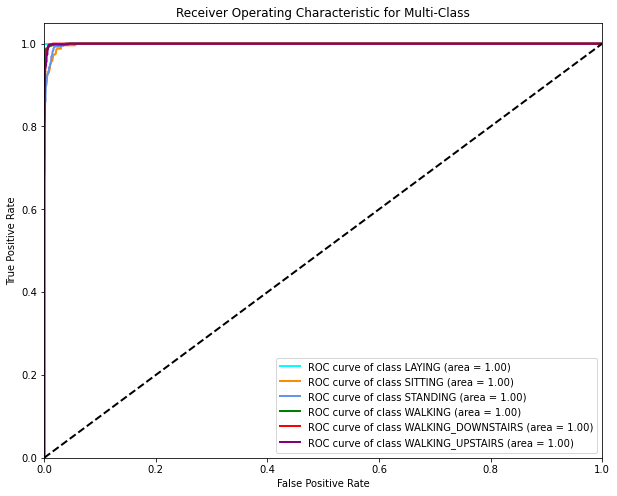

Random Forest ROC AUC per class: {0: 1.0, 1: 0.9984420467828985, 2: 0.9985998463486003, 3: 0.9997990211057725, 4: 0.9995915544965581, 5: 0.9994698841698841}


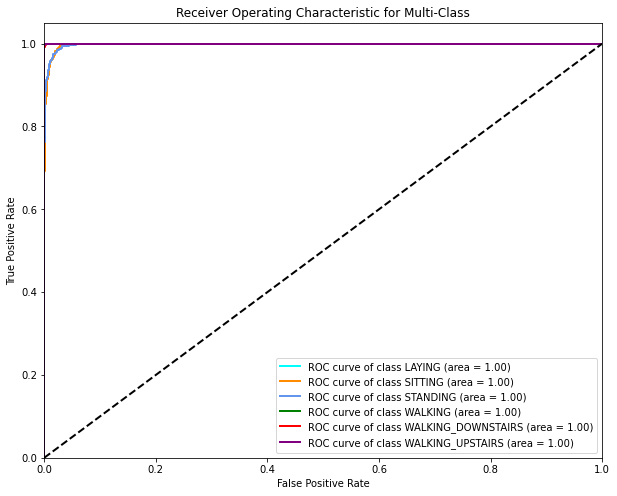

SVM ROC AUC per class: {0: 1.0, 1: 0.9981610789166065, 2: 0.998368596071838, 3: 0.9999977585996926, 4: 0.9999860658250426, 5: 0.9999891891891892}


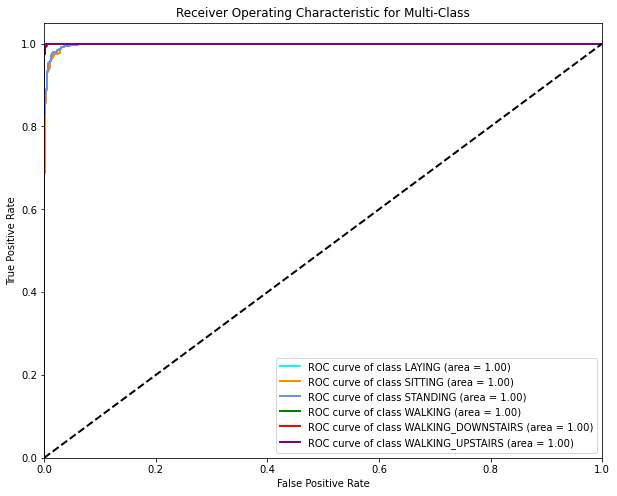

Neural Network ROC AUC per class: {0: 1.0, 1: 0.9981191086129281, 2: 0.9984782466589959, 3: 0.9999850573312842, 4: 0.9999407797564306, 5: 0.9999505791505792}


In [39]:
# Predict probabilities for each class using Logistic Regression and SVM
logistic_probs = logistic_model.predict_proba(X_test)
random_forest_probs = random_forest_model.predict_proba(X_test)
svm_probs = svm_model.predict_proba(X_test)  # Ensure that SVM is initialized with probability=True

# Class labels (ensure these match the actual class labels used)
class_labels = np.unique(Y)

# ROC AUC for Logistic Regression
logistic_roc_auc = plot_roc_curve(Y_test, logistic_probs, class_labels)
print("Logistic Regression ROC AUC per class:", logistic_roc_auc)

# ROC AUC for Random Forest
random_forest_roc_auc = plot_roc_curve(Y_test, random_forest_probs, class_labels)
print("Random Forest ROC AUC per class:", random_forest_roc_auc)

# ROC AUC for SVM
svm_roc_auc = plot_roc_curve(Y_test, svm_probs, class_labels)
print("SVM ROC AUC per class:", svm_roc_auc)

# For the neural network, we need to handle probabilities differently
nn_probs = nn_model.predict(X_test_nn)
nn_roc_auc = plot_roc_curve(Y_test, nn_probs, class_labels)
print("Neural Network ROC AUC per class:", nn_roc_auc)

## Conclusion

Due to the very high ROC AUC values for the models we will exercise caution in using the merged dataset given that in the original dataset specific instructions suggest the training data was specifically separated.